In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpContinuous, PULP_CBC_CMD
import numpy as np

In [2]:

print("EVCS placement optimisation model with the objective to minimise the total operational cost")

EVCS placement optimisation model with the objective to minimise the total operational cost


In [3]:

# Read data
network_df = pd.read_csv('data/network.csv')

# Read data
demand_df = pd.read_csv('data/ev_demand.csv')


print(network_df.head())
print(demand_df.head())

   Link  From  To  Capacity  Distance
0     1     1   2      1500         6
1     2     1   3      1500         4
2     3     2   1      1500         6
3     4     2   6      1500         5
4     5     3   1      1500         4
   Node  EV demand
0     1         11
1     2         14
2     3         10
3     4         15
4     5         12


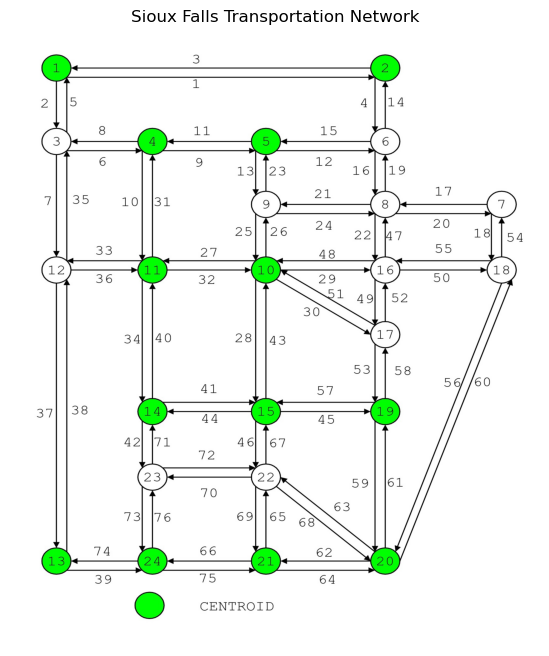

In [4]:
img = Image.open("data/Sioux-Falls-Network.jpg")
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Sioux Falls Transportation Network")
plt.show()

In [5]:
# node list
nodes = sorted(set(network_df['From']).union(network_df['To']))

# Demand 
demand = dict(zip(demand_df['Node'], demand_df['EV demand']))
for n in nodes:
    demand.setdefault(n, 0)

# Symmetric distance matrix
dist_matrix = {(row['From'], row['To']): row['Distance'] for _, row in network_df.iterrows()}
for i, j in list(dist_matrix):
    dist_matrix[(j, i)] = dist_matrix[(i, j)]

# Parameters
coverage_radius = 20
max_stations = 10
station_cost = 1000
per_km_cost = 2


model = LpProblem("EVCS_Operational_Cost_Minimisation", LpMinimize)


x = {j: LpVariable(f"x_{j}", cat=LpBinary) for j in nodes}
y = {
    (i, j): LpVariable(f"y_{i}_{j}", lowBound=0, cat=LpContinuous)
    for i in nodes for j in nodes
    if (i, j) in dist_matrix and dist_matrix[i, j] <= coverage_radius
}


model += (
    lpSum(x[j] * station_cost for j in nodes) +
    lpSum(y[i, j] * dist_matrix[i, j] * per_km_cost for (i, j) in y)
)


for i in nodes:
    model += lpSum(y[i, j] for j in nodes if (i, j) in y) == demand[i]


for (i, j) in y:
    model += y[i, j] <= demand[i] * x[j]


model += lpSum(x[j] for j in nodes) <= max_stations


model.solve(PULP_CBC_CMD(msg=1))

# Results
selected_stations = [j for j in nodes if x[j].varValue > 0.5]
assignments = [(i, j, y[i, j].varValue) for (i, j) in y if y[i, j].varValue > 0.01]

print("\n🚉 Selected EVCS Locations:")
print(selected_stations)

print("\n🔌 Demand Assignments (i → j):")
for i, j, amt in assignments:
    if x[j].varValue < 0.5:
        print(f"⚠️  ERROR: Assigned demand to node {j}, which has no station!")
    print(f"  Node {i} → Charging Station {j}: {amt:.1f} units")


🚉 Selected EVCS Locations:
[3, 6, 8, 12, 16, 17, 22, 23]

🔌 Demand Assignments (i → j):
  Node 1 → Charging Station 3: 11.0 units
  Node 2 → Charging Station 6: 14.0 units
  Node 3 → Charging Station 12: 10.0 units
  Node 4 → Charging Station 3: 15.0 units
  Node 5 → Charging Station 6: 12.0 units
  Node 6 → Charging Station 8: 10.0 units
  Node 7 → Charging Station 8: 14.0 units
  Node 8 → Charging Station 6: 9.0 units
  Node 9 → Charging Station 8: 5.0 units
  Node 10 → Charging Station 16: 12.0 units
  Node 11 → Charging Station 12: 11.0 units
  Node 12 → Charging Station 3: 15.0 units
  Node 13 → Charging Station 12: 11.0 units
  Node 14 → Charging Station 23: 12.0 units
  Node 15 → Charging Station 22: 10.0 units
  Node 16 → Charging Station 17: 12.0 units
  Node 17 → Charging Station 16: 13.0 units
  Node 18 → Charging Station 16: 7.0 units
  Node 19 → Charging Station 17: 15.0 units
  Node 20 → Charging Station 22: 9.0 units
  Node 21 → Charging Station 22: 9.0 units
  Node 22 